In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
csv_file = 'data/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'RH']
full = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'rh']

bad_dates = ['2019-08-21', '2019-08-22', '2019-09-24']
GA = full.loc[(full['id'] == 'GA1') & (~full['date'].isin(bad_dates)) , :]

In [3]:
from sklearn.linear_model import LinearRegression

y = GA['pm25pa']
X = GA[['pm25aqs', 'rh']]

model2 = LinearRegression().fit(X, y)


# Bootstrapping for Inference

In many hypothesis tests the assumptions of the null hypothesis lead to a complete specification of a hypothetical population and data design (see {numref}`Figure %s  <triptych>`), and we use this specification to simulate the sampling distribution of a statistic.  For example, the rank test for the Wikipedia experiment, led us to sampling the integers 1, ..., 200, which we easily simulated.  Unfortunately, we can't always specify the population and  model completely. To remedy the situation, we substitute the data for the population. This substitution is at the heart of the notion of the bootstrap. {numref}`Figure %s  <boot-triptych>` updates {numref}`Figure %s  <triptych>` to reflect this idea; here the population distribution is replaced by the empirical distribution to create what is called the *bootstrap population*. 

```{figure} bootTriptych.png
---
name: boot-triptych
---

This diagram imitates the data generation process by bootstrapping. Comparing this figure to {numref}`Figure %s <triptych>`, you can see that the sample has been placed in the urn as a substitute for the population. The far right side shows a bootstrap sample taken using the same chance process as in the original study. In the middle, the sampling distribution of the bootstrap statistic is still a probability distribution based on the same mechanism for selecting the sample as in the original model, but now uses the bootstrap population. 
```

The rationale for the bootstrap goes like this:
+ Your sample looks like the population because it is a representative sample so we replace  the population with the sample and call it the bootstrap population.
+ Use the same data generation process that produced the original sample to get a new sample, which is called a *bootstrap sample* to reflect the change in the population. Calculate the statistic on the bootstrap sample in the same manner as before and call it the *bootstrap statistic*. The *bootstrap sampling distribution* of the bootstrap statistic should be similar in shape and spread to the true sampling distribution of the statistic.
+ Simulate the data generation process many times, using the bootstrap population, to get bootstrap samples and their bootstrap statistics. The distribution of the simulated bootstrap statistics approximates the bootstrap sampling distribution of the bootstrap statistic,
which itself approximates the original sampling distribution. 

Take a close look at {numref}`Figure %s  <boot-triptych>` and compare it to {numref}`Figure %s  <triptych>`.  Essentially, the bootstrap simulation involves two approximations: the original sample approximates the population, and the simulation approximates the sampling distribution. We have been using the second approximation in our examples so far; the approximation of the population by the sample is the core notion behind bootstrapping.   
  
You might be wondering how to take a simple random sample from your bootstrap population and not wind up with the exact same sample each time. After all, if your sample has 100 units in it and you use it as your bootstrap population, then 100 draws from the bootstrap population without replacement will take all of the units and give you the same bootstrap sample every time. There are two approaches to solving this problem. The first is by far the most common.

+ If the original population is very large, then there is little difference between sampling with and without replacement so when sampling from the bootstrap population, make draws with replacement.
+ "Blow up the sample" to be the same size as the original population. That is, tally up the fraction of each unique value in the sample, and add units to the bootstrap population so it is the same size as the original population, while maintaining the proportions. For example, if the sample is size 30 and 1/3 of the sample values are 0, then a bootstrap population of 750 should include 250 zeroes. Once you have this bootstrap population, use the original data generation procedure to take the bootstrap samples. 

The example of vaccine efficacy, used a bootstrap-like process, called the *parameterized bootstrap*. Our null model specified 0-1 urns, but we didn't know how many 0s and 1s to put in the urn. We used the sample to determine the proportions of 0s and 1s; that is, the sample specified the parameters of the multivariate hypergeometric.     

:::{warning}

It's a common mistake to think that the center of the bootstrap sampling distribution is the same as the center of the true sampling distribution. If the mean of the sample is not 0 then the mean of the bootstrap population is also not 0. That's why we use the spread of the bootstrap distribution, and not its center, in hypothesis testing. The next example shows how we might use the bootstrap to test a hypothesis.

:::

## Boostrapping a Test for a Regression Coefficient 

The case study on calibrating air quality monitors (see {numref}`Chapter %s <ch:pa>`) fitted a model to adjust the measurements from an inexpensive monitor to more accurately reflected true air quality. This adjustment included a term in the model related to humidity. The fitted coefficient was about $0.2$, so that on days of high humidity the  measurement is adjusted upward more than on days of low humidity. However, this coefficient is close to 0, and we might wonder whether including humidity in the model is really needed. In other words, we want to test the hypothesis that the coefficient for humidity in the linear model is 0. Unfortunately, we can't fully specify the model because it is based on measurements taken over a particular time period from a set of air monitors (both PurpleAir and those maintained by the EPA). This is where the bootstrap can help. 

Our model makes the assumption that the air quality measurements taken resemble the population of measurements. Note that weather conditions, the time of year, and the location of the monitors makes this statement a bit hand-wavy; what we mean here is that the measurements are similar to others taken under the same conditions as those when the original measurement were taken. Also, since we can imagine a virtually infinite supply of air quality measurements, we think of the procedure for generating measurements as draws with replacement from the urn. Recall that in {numref}`Chapter %s <ch:data_scope>` we modeled the urn as repeated draws with replacement from an urn of measurement errors. This situation is a bit different because we 
are also including the other factors mentioned already (weather, season, location).

Our model is focussed on the coefficient for humidity in the linear model:

$$
\begin{aligned}
\text{PA} \approx \theta_0 + \theta_1 \text{AQ} + \theta_2 \text{RH} 
\end{aligned}
$$

Here, $\text{PA}$ refers to the PurpleAir PM2.5 measurement, $ \text{RH}$ is the
relative humidity, and $\text{AQ}$ stands for the more exact measurement of PM2.5 made by the more accurate AQS monitors.
The null hypothesis is $\theta_2 = 0$; that is, the null model is the simpler model:

$$
\begin{aligned}
\text{PA} \approx \theta_0 + \theta_1 \text{AQ}
\end{aligned}
$$

To estimate $\theta_2$, we use the linear model fitting procedure from {numref}`Chapter %s <ch:linear>`. 

Our bootstrap population consists of the measurements from Georgia that we used in {numref}`Chapter %s <ch:linear>`). Now, we sample rows from the data frame (which is equivalent to our urn) with replacement using the chance mechanism `randint`. This function takes random samples with replacement from a set of integers. We use the random sample of indices to create the bootstrap sample from the data frame. Then we fit the linear model and get the coefficient for humidity (our bootstrap statistic). The `boot_stat` function below performs this simulation process.

In [4]:
def boot_stat(X, y):
    r = randint.rvs(low=0, high=(n-1), size=n)
    
    theta2 = LinearRegression().fit(X.iloc[r, :], y.iloc[r]).coef_[1]
    
    return theta2

We set up the design matrix and the outcome variable and check our `boot_stat` function once to test it.

In [5]:
from scipy.stats import randint


n = len(GA)
y = GA['pm25pa']
X = GA[['pm25aqs', 'rh']]

boot_stat(X, y)

0.20390167910281556

When we repeat this process 10,000 times, we get an approximation to the bootstrap sampling distribution of the bootstrap statistic (the fitted humidity coefficient).

In [6]:
rng = np.random.default_rng(42)

boot_theta_hat = [boot_stat(X, y) for _ in range(10000)]

We are interested in the shape and spread of this bootstrap sampling distribution. (We know that the center will be close to the original coefficient of $0.21$.)

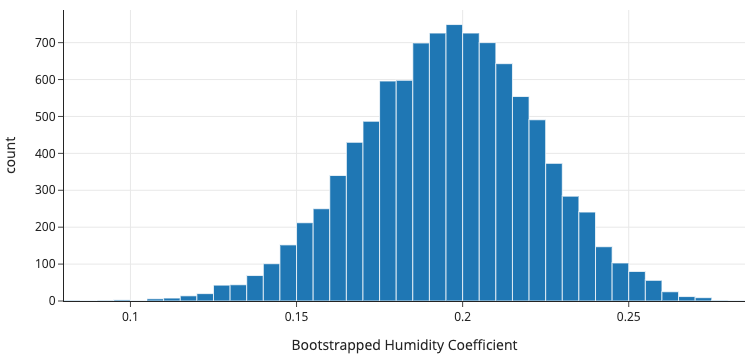

In [8]:
px.histogram(x=boot_theta_hat, nbins=50,
            labels=dict(x='Bootstrapped Humidity Coefficient'),
            width=350, height=250)

By design, the center of the bootstrap sampling distribution will be near $\hat{\theta}$ because the bootstrap population consists of the observed data. 
So, rather than compute the chance of a value at least as large as the observed statistic, we find the chance of a value at least as small as 0.
The hypothesized value of 0 is far from the sampling distribution: 

In [9]:
len([elem for elem in boot_theta_hat if elem < 0.0]) 

0

None of the 10,000 simulated regression coefficients are as small as the hypothesized coefficient. Statistical logic leads us to reject the null hypothesis that we do not need to adjust the model for humidity. 

The form of the hypothesis test we performed here looks different than the earlier tests because the sampling distribution of the statistic is not centered on the null. That is because we are using the bootstrap to create the sampling distribution. We are in effect using a confidence interval for the coefficient to test the hypothesis.  In the next section we introduce interval estimates more generally, including those based on the bootstrap, and we connect the concepts of hypothesis testing and confidence intervals.